# Toxic Comment Classification

## Project Objective
Classify comments as toxic or non-toxic using multi-label classification. The model should be able to identify various types of toxicity such as toxic, severe toxic, obscene, threat, insult, and identity hate within comments.

### Dataset
The project uses the Jigsaw Toxic Comment Classification dataset from Kaggle, which contains thousands of comments labeled across multiple toxicity categories. The dataset includes:
* Training data with comments and their corresponding toxicity labels.
* Test data without labels for prediction.
* A sample submission file to format your output predictions.

### load dataset

In [6]:
import pandas as pd

train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

print("Train data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
train_df.head()

Train data shape: (159571, 8)
Test data shape: (153164, 2)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Preprocessing Plan for Toxic Comment Dataset

1) Handle Missing Values
* Check if any comment texts are missing and handle them.
  
2) Text Cleaning
* Lowercase all text
* Remove unnecessary characters (punctuation, numbers, special symbols)
* Remove extra whitespace
  
3) Tokenization (using spaCy)
* Split text into meaningful tokens
* Remove stopwords (optional)
* Lemmatization (convert words to base form)

4) Exploratory Data Analysis (Optional but useful)
* Visualize word clouds for toxic vs non-toxic comments
* Check class imbalance

``` save preprocessed dataset ```

In [2]:
missing_count = train_df['comment_text'].isnull().sum()
print(f"Missing values in comment_text: {missing_count}")

train_df['comment_text'] = train_df['comment_text'].fillna("")

print(f"Missing values after replacement: {train_df['comment_text'].isnull().sum()}")

Missing values in comment_text: 0
Missing values after replacement: 0


In [7]:
import pandas as pd
import numpy as np
import multiprocessing as mp
import spacy
from tqdm import tqdm

# tqdm for multiprocessing
tqdm.pandas()

# This will be loaded inside each process
nlp = None

def init_spacy():
    global nlp
    nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    text = text.lower()
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

def preprocess_df(df):
    df['clean_comment'] = df['comment_text'].fillna("").progress_apply(preprocess_text)
    return df

def parallelize_dataframe(df, func, n_cores=None):
    if n_cores is None:
        n_cores = mp.cpu_count()
    df_split = np.array_split(df, n_cores)
    with mp.Pool(n_cores, initializer=init_spacy) as pool:
        results = list(tqdm(pool.imap(func, df_split), total=n_cores))
    return pd.concat(results)

def clean_dataset(file_name):
    df = pd.read_csv(file_name)
    # Use all CPU cores available
    n_cores = mp.cpu_count()
    # Run preprocessing in parallel with progress bar
    processed_df = parallelize_dataframe(df, preprocess_df, n_cores=n_cores)
    processed_df.to_csv(file_name.replace(".csv","_cleaned.csv"), index=False)
    print(processed_df.head())
    return processed_df
    
clean_dataset("../data/test.csv")

/home/jenil/Desktop/NLP_project/env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
100%|████████████████████████████████████████████| 8/8 [29:20<00:00, 220.07s/it]


                 id                                       comment_text  \
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...   
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...   
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...   
3  00017563c3f7919a  :If you have a look back at the source, the in...   
4  00017695ad8997eb          I don't anonymously edit articles at all.   

                                       clean_comment  
0  yo bitch ja rule succesful s hate sad mofucka ...  
1                   = = rfc = = \n\n  title fine imo  
2  \n\n  = = source = = \n\n  zawe ashton lapland...  
3  look source information update correct form gu...  
4                           anonymously edit article  


,id,comment_text,clean_comment
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,yo bitch ja rule succesful s hate sad mofucka ...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,= = rfc = = \n\n title fine imo
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",\n\n = = source = = \n\n zawe ashton lapland...
3,00017563c3f7919a,":If you have a look back at the source, the in...",look source information update correct form gu...
4,00017695ad8997eb,I don't anonymously edit articles at all.,anonymously edit article
...,...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",\n totally agree stuff long crap
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,= = throw field home plate = = \n\n fast thro...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",\n\n = = okinotorishima category = = \n\n ch...
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",\n\n = = found nation eu germany law return s...


* load saved preprocessed data

In [12]:
train_df = pd.read_csv('../data/train_cleaned.csv')

### Exploratory Data Analysis (EDA)

1. Class Distribution
Understand how many comments are toxic, severe toxic, etc.

In [ ]:
import matplotlib.pyplot as plt
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
label_counts = train_df[label_cols].sum().sort_values()
print(label_counts)
label_counts.plot(kind='barh', title='Label Distribution')
plt.xlabel("Count")
plt.show()


2. Check Multilabel Overlap
Some comments have more than one toxic label.

In [44]:
train_df['num_labels'] = train_df[label_cols].sum(axis=1)
print(train_df['num_labels'].value_counts())

num_labels
0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: count, dtype: int64


3. Comment Length Distribution

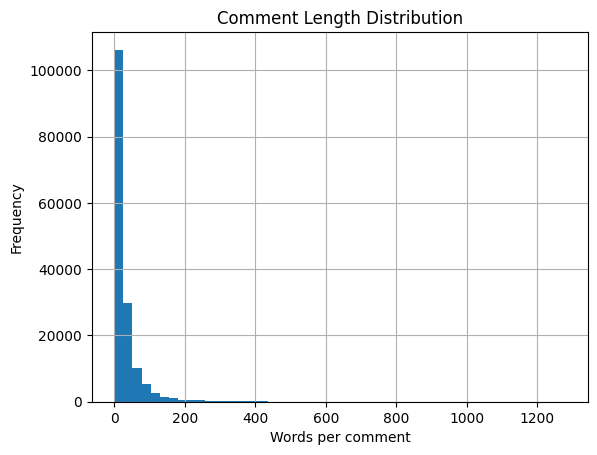

In [45]:
train_df['comment_len'] = train_df['clean_comment'].apply(lambda x: len(str(x).split()))
train_df['comment_len'].hist(bins=50)
plt.title("Comment Length Distribution")
plt.xlabel("Words per comment")
plt.ylabel("Frequency")
plt.show()

4. Word Clouds (for visualizing common toxic vs non-toxic words)

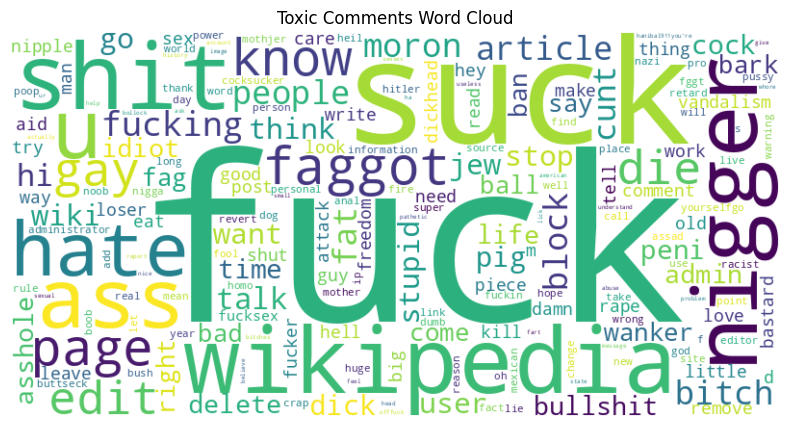

In [46]:
from wordcloud import WordCloud, STOPWORDS

custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["hi", "dont", "youre", "got", "get", "like", "one", "also", "know", "would", "people"])
# Toxic comments only
toxic_comments = " ".join(train_df[train_df['toxic'] == 1]['clean_comment'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white',collocations=False).generate(toxic_comments)


plt.figure(figsize=(15, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Toxic Comments Word Cloud')
plt.show()


### Feature Extraction for Toxic Comment Classification

In [47]:
# limit first 1000 data sets
# train_df = train_df[:1000]

In [48]:
# run to install libraries
# !pip install transformers torch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [14]:
import torch
from transformers import AutoTokenizer, AutoModel
def extrect_features(df,name):
    # Load Huggingface tokenizer and model (DistilBERT)
    model_name = "distilbert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    model.eval()  # Inference mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    model.to(device)
    
    # Tokenize texts in batches
    batch_size = 32
    all_embeddings = []
    texts = df['clean_comment'].fillna("").astype(str).tolist()
    # Label columns
    label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    y = df[label_cols].values
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Extracting embeddings"):
        batch_texts = texts[i:i+batch_size]
        
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        ).to(device)
    
        with torch.no_grad():
            outputs = model(**inputs)
            embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token
            all_embeddings.append(embeddings.cpu())
    
    # Combine all batches
    features = torch.cat(all_embeddings).numpy()
    
    # Save embeddings and labels to disk
    np.save(f"../features/{name}_bert_features.npy", features)
    np.save(f"../features/{name}_bert_labels.npy", y)
    print("✅ Embeddings shape:", features.shape)
    print("✅ Labels shape:", y.shape)

extrect_features(train_df,"train")

test_input = pd.read_csv('../data/test_cleaned.csv')
test_label = pd.read_csv('../data/test_labels.csv') 
test_df = pd.merge(test_input, test_label, on='id', how='inner')
test_df.head()
extrect_features(train_df,"test")

Using device: cpu


Extracting embeddings:   0%|                | 11/4987 [00:11<1:28:26,  1.07s/it]


KeyboardInterrupt: 

In [ ]:
def load_features_and_labels(prefix="train"):
    features = np.load(f"../features/{prefix}_bert_features.npy")
    labels = np.load(f"../features/{prefix}_bert_labels.npy")
    print(f"✅ Loaded: {prefix}_bert_features.npy and {prefix}_bert_labels.npy")
    return features, labels

In [ ]:
!pip install scikit-learn joblib

### Train Model

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
import joblib

# load features from storage
X_train, y_train = load_features_and_labels(prefix="train")

base_model = LogisticRegression(max_iter=1000)
clf = MultiOutputClassifier(base_model)
clf.fit(X_train, y_train)

# Step 4: Save the trained model
joblib.dump(clf, "../models/logreg_multi_label_model.pkl")
print("✅ Model saved to: ../models/logreg_multi_label_model.pkl")

### Evaluate Model

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, hamming_loss
import joblib

# Load saved features and labels for test set
X_test, y_test = load_features_and_labels(prefix="test")

# Load the trained model from disk
clf = joblib.load("../models/logreg_multi_label_model.pkl")

# Predict on test data
y_pred = clf.predict(X_test)

label_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Print classification report
print("📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_names))

# Additional evaluation metrics (optional)
exact_match = accuracy_score(y_test, y_pred)
hamming = hamming_loss(y_test, y_pred)

print(f"Exact Match Ratio (Accuracy): {exact_match:.4f}")
print(f"Hamming Loss: {hamming:.4f}")